In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from compute_transport import *
from compute_xgboost import *
from evaluation_metrics import *
import torch
import torch.nn.functional as F

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(20, 10), facecolor='white')

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                         11.1.0
anyio                       NA
appnope                     0.1.2
asttokens                   NA
attr                        24.3.0
attrs                       24.3.0
babel                       2.16.0
backports                   NA
brotli                      1.0.9
certifi                     2025.01.31
charset_normalizer          3.3.2
comm                        0.2.1
compute_transport           NA
compute_xgboost             NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.11
decorator                   5.1.1
defusedxml                  0.7.1
einops                      0.8.1
evaluation_metrics          NA
exceptiongroup              1.2.0
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
ipykernel                   6.29.5
ipywi

In [3]:
df_fov = pd.read_pickle('mk_bc_fov.pkl')
df_fov = df_fov[df_fov.index != 'OFFx']
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
DB3b,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB5*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB5*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Generate unique mapping for index values
unique_index_values = df_fov.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_fov.index = df_fov.index.map(index_mapping)
df_fov

Mapping of annotated values to numbers:
{'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# fov_index_mapping = {'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'OFFx': 10, 'DB3a': 11}
fov_index_mapping = {'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}
fov_bc_mapping = {value: key for key, value in fov_index_mapping.items()}
fov_bc_mapping

{0: 'DB3b',
 1: 'FMB',
 2: 'IMB',
 3: 'DB5*',
 4: 'DB4',
 5: 'DB2',
 6: 'DB1',
 7: 'BB/GB*',
 8: 'RB',
 9: 'DB6',
 10: 'DB3a'}

In [6]:
# transform cell type index into a number between 100 and 200
df_fov.index = df_fov.index+101
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_per = pd.read_pickle('mk_bc_per.pkl')
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
FMB,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
DB2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [8]:
# Generate unique mapping for index values
unique_index_values = df_per.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_per.index = df_per.index.map(index_mapping)
df_per

Mapping of annotated values to numbers:
{'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
1,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [9]:
per_index_mapping = {'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}
per_bc_mapping = {value: key for key, value in per_index_mapping.items()}
per_bc_mapping

{0: 'RB',
 1: 'FMB',
 2: 'DB2',
 3: 'IMB',
 4: 'DB5*',
 5: 'DB3b',
 6: 'DB3a',
 7: 'BB/GB*',
 8: 'DB1',
 9: 'DB4',
 10: 'DB6'}

In [10]:
# transform cell type index into a number above 200
df_per.index = df_per.index+201
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
202,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
203,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
204,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [11]:
df = pd.concat([df_fov, df_per], axis=0)
df

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [12]:
# Calculate counts, means, and variances per cell type
type_counts = df.groupby(df.index).count()  # Count of cells per type
type_means = df.groupby(df.index).mean()    # Mean expression per type
type_vars = df.groupby(df.index).var()      # Variance per type

# Calculate SEM for each type
type_sems = type_vars.div(type_counts - 1).pow(0.5)  # SEM = sqrt(var/(n-1))

# Calculate overall mean expression for each gene
overall_means = df.mean()

# Calculate signal
signal = ((type_means - overall_means)**2).sum()

# Calculate noise
noise = (type_sems**2).sum()

# Calculate SNR, avoiding division by zero
snr = signal / np.maximum(noise, 1e-20)

# Sort genes by SNR in descending order
sorted_genes = snr.sort_values(ascending=False)

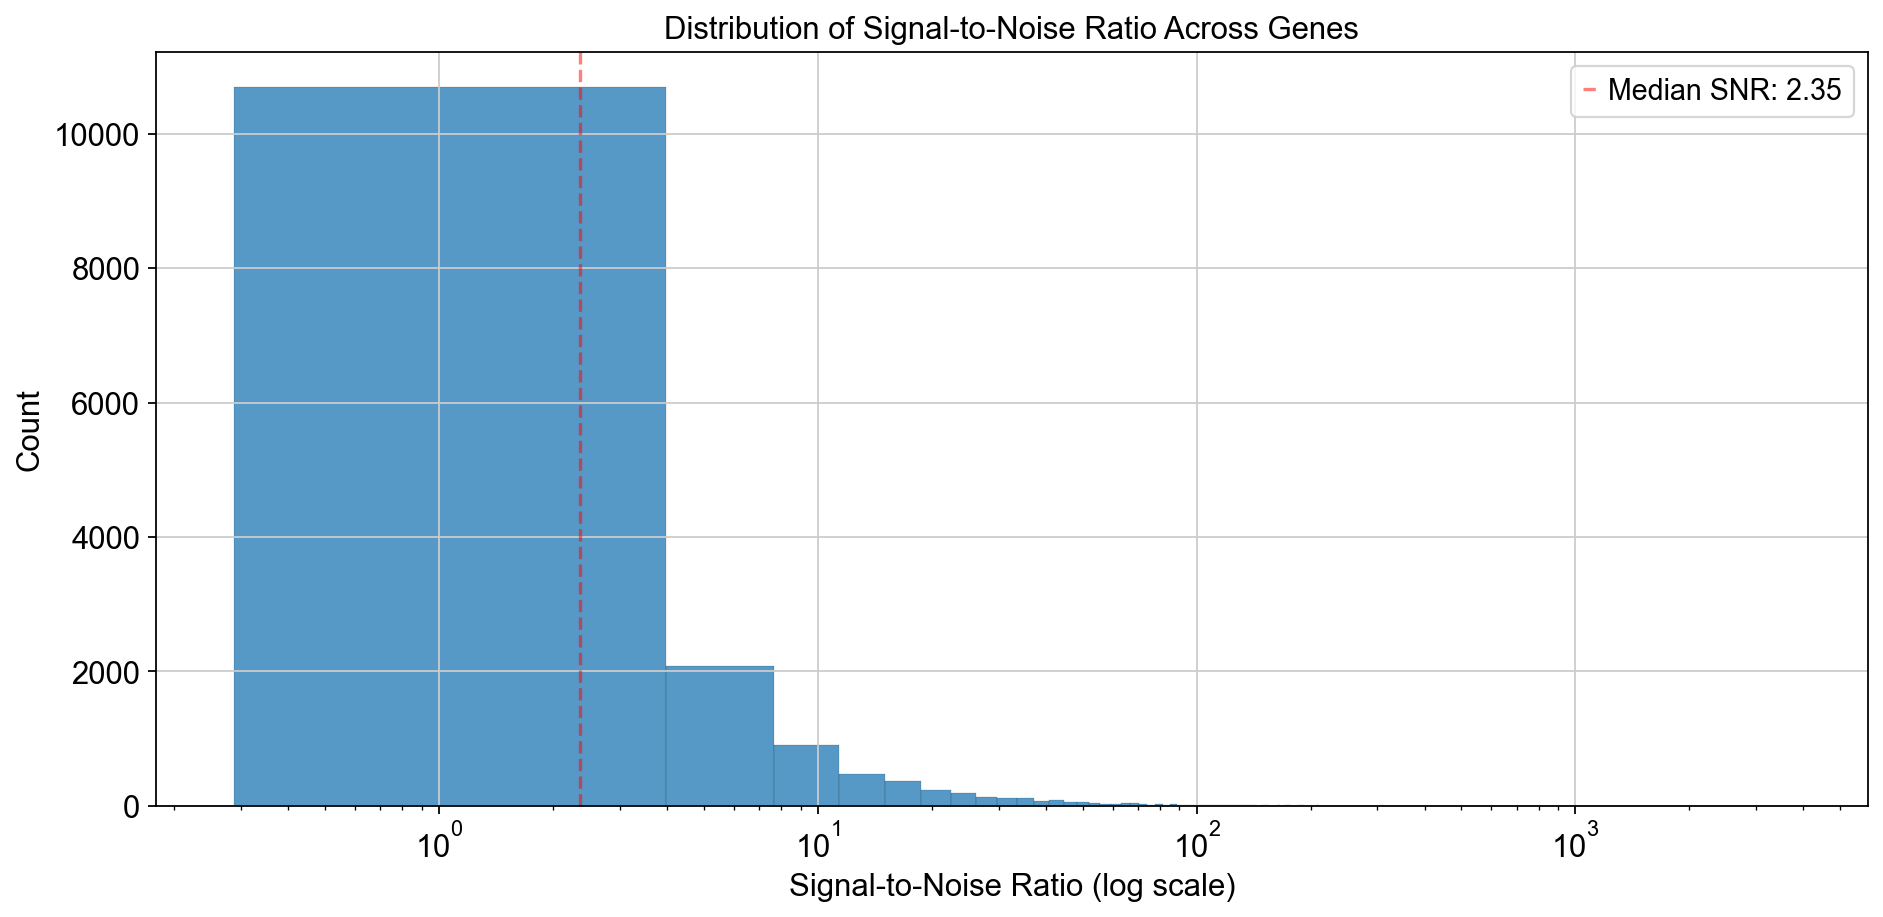


SNR Summary Statistics:
count    16161.000000
mean        10.884119
std         52.221137
min          0.286768
25%          1.365612
50%          2.353347
75%          6.032673
max       3688.980919
dtype: float64


In [13]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(data=snr, bins=1000)

# Add log scale for x-axis since SNR values often span several orders of magnitude
plt.xscale('log')

# Customize the plot
plt.title('Distribution of Signal-to-Noise Ratio Across Genes')
plt.xlabel('Signal-to-Noise Ratio (log scale)')
plt.ylabel('Count')

# Add grid for better readability
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Optional: Add vertical line at median
plt.axvline(snr.median(), color='r', linestyle='--', alpha=0.5, label=f'Median SNR: {snr.median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSNR Summary Statistics:")
print(snr.describe())

In [14]:
# Select genes with high SNR
high_snr_genes = snr[snr > 100]

# Print number of selected genes
print(f"Number of genes with great SNR: {len(high_snr_genes)}")

# Create filtered dataframe with only high SNR genes
df_filtered = df[high_snr_genes.index]

# Optional: Display first few rows and shape of filtered dataframe
print(f"\nShape of filtered dataframe: {df_filtered.shape}")
print("\nFirst few rows of filtered dataframe:")
print(df_filtered.head())

Number of genes with great SNR: 271

Shape of filtered dataframe: (30155, 271)

First few rows of filtered dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22359  MSTRG.22360  \
101            0.0  0.000000  0.000000  ...     0.641217     3.033673   
102            0.0  1.392702  0.000000  ...     0.697424     1.392702   
103            0.0  0.000000  0.000000  ...     0.782327     2.457792   
104            0.0  0.000000  0.646688  ...     0.000000     2.954085   
105            0.0  0.000000  0.000000  ...     0.980239    

In [15]:
fov_sub_df = df_filtered[df_filtered.index < 200]
per_sub_df = df_filtered[df_filtered.index >= 200]

# Print information about the split
print(f"Fovea dataframe shape: {fov_sub_df.shape}")
print(f"Peripheral dataframe shape: {per_sub_df.shape}")

# Optional: Display first few rows of each
print("\nFirst few rows of fovea dataframe:")
print(fov_sub_df.head())
print("\nFirst few rows of peripheral dataframe:")
print(per_sub_df.head())

Fovea dataframe shape: (20870, 271)
Peripheral dataframe shape: (9285, 271)

First few rows of fovea dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22359  MSTRG.22360  \
101            0.0  0.000000  0.000000  ...     0.641217     3.033673   
102            0.0  1.392702  0.000000  ...     0.697424     1.392702   
103            0.0  0.000000  0.000000  ...     0.782327     2.457792   
104            0.0  0.000000  0.646688  ...     0.000000     2.954085   
105            0.0  0.000000  0.000000  ...     0.980239     3.043

In [16]:
# transform the index back to cell type names
per_sub_df.index = per_sub_df.index - 201
# per_sub_df.index = per_sub_df.index.map(per_bc_mapping)
# per_sub_df

In [17]:
# transform the index back to cell type names
fov_sub_df.index = fov_sub_df.index - 101
# fov_sub_df.index = fov_sub_df.index.map(fov_bc_mapping)
# fov_sub_df

In [18]:
# for plotting in the same order as that in Peng, et al. (2019)
desired_order1 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    # "OFFx",   # OFFx
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

desired_order2 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

In [19]:
def plot_confusion_matrix(confusion_matrix, figsize=(10, 8), cmap="bwr"):
    """
    Plot reordered confusion matrix for better visualization
    
    Parameters:
    -----------
    confusion_matrix : DataFrame
        Confusion matrix to plot
    figsize : tuple
        Figure size
    cmap : str
        Colormap for the heatmap
    """
    # Reorder matrix to place highest values on diagonal
    def reorder_matrix(cm):
        # Calculate best matching by greedy assignment
        ordered_rows = []
        ordered_cols = []
        
        cm_copy = cm.copy()
        remaining_rows = list(cm_copy.index)
        remaining_cols = list(cm_copy.columns)
        
        while len(remaining_rows) > 0 and len(remaining_cols) > 0:
            max_val = -1
            max_row = None
            max_col = None
            
            for row in remaining_rows:
                for col in remaining_cols:
                    if cm_copy.loc[row, col] > max_val:
                        max_val = cm_copy.loc[row, col]
                        max_row = row
                        max_col = col
            
            ordered_rows.append(max_row)
            ordered_cols.append(max_col)
            remaining_rows.remove(max_row)
            remaining_cols.remove(max_col)
        
        # Add any remaining rows or columns
        ordered_rows.extend(remaining_rows)
        ordered_cols.extend(remaining_cols)
        
        return cm.loc[ordered_rows, ordered_cols]
    
    # Reorder the matrix
    reordered_cm = reorder_matrix(confusion_matrix)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        reordered_cm, 
        annot=True, 
        fmt=".2f", 
        cmap=cmap,
        cbar_kws={'label': 'Prediction Probability'}
    )
    plt.title("Cross-Species Cell Type Prediction")
    plt.ylabel("True Cell Type")
    plt.xlabel("Predicted Cell Type")
    plt.tight_layout()
    return plt

Processing input data...
Using 271 common genes between species
Training XGBoost model...
Validation accuracy: 0.9806
Predicting cell types for Fovea...
Creating confusion matrix...
Running Time: 2.306246 seconds


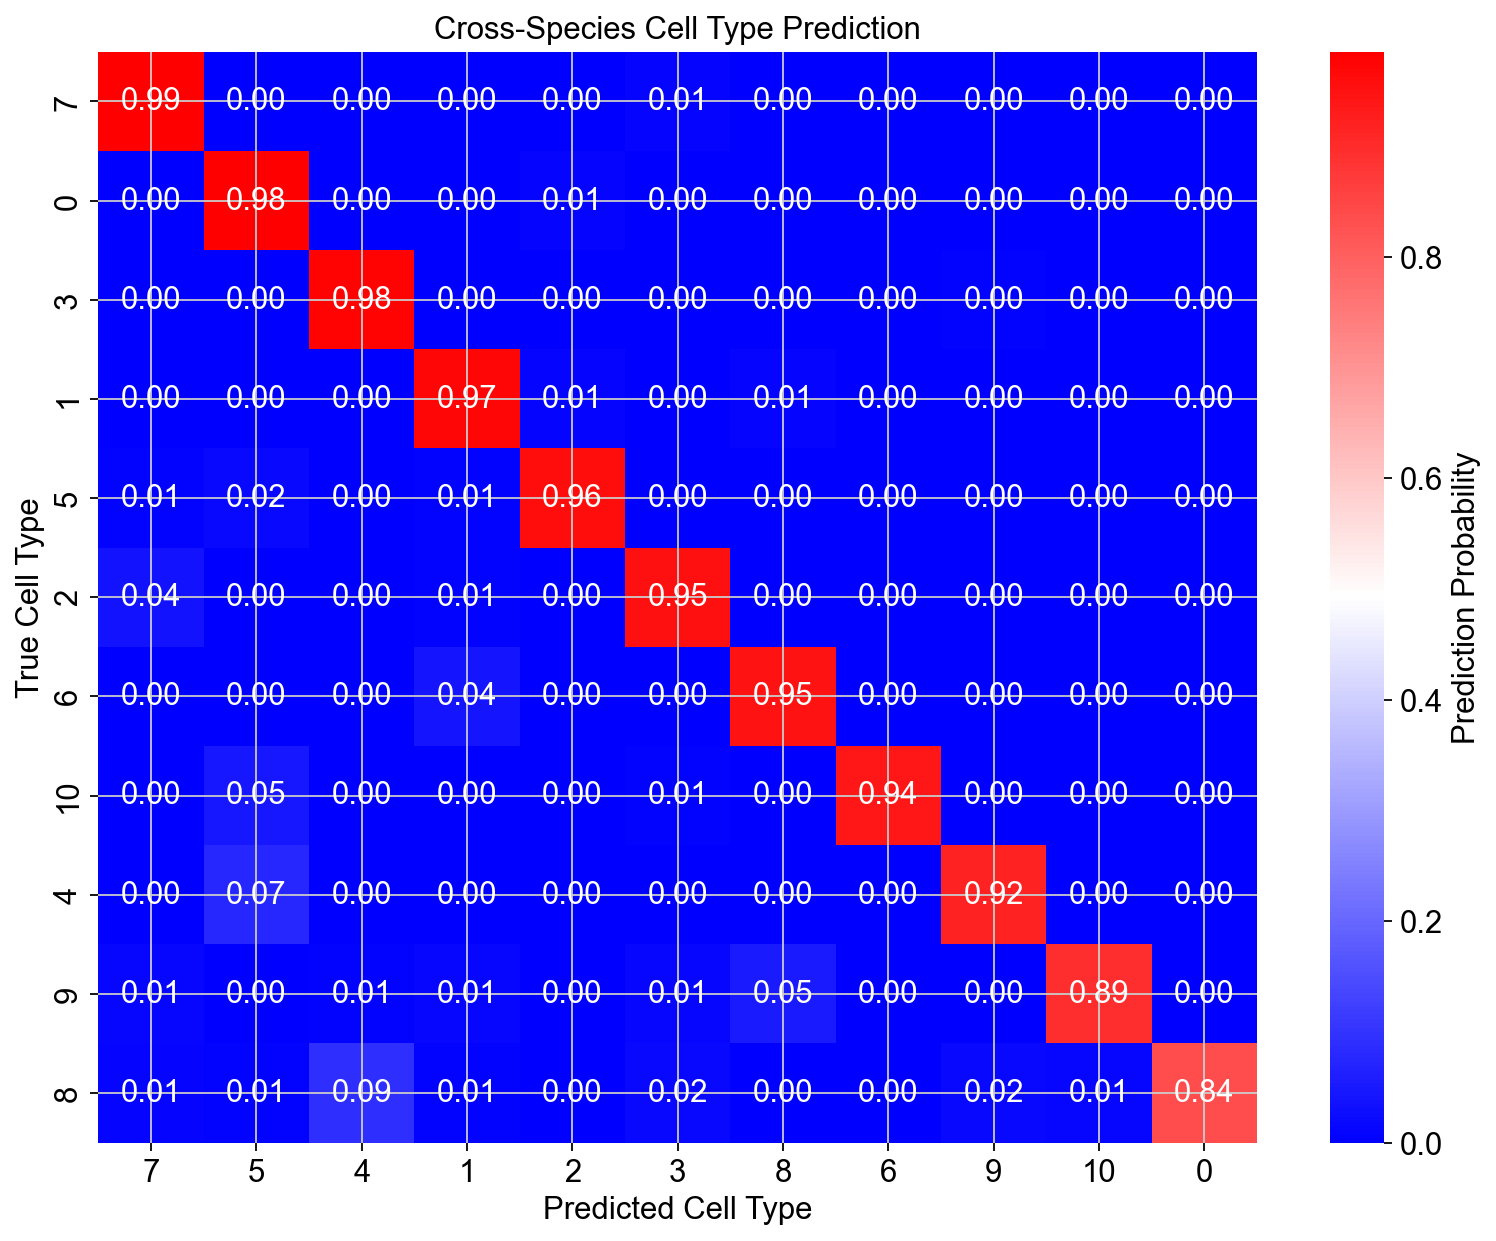

In [20]:
labels_per = per_sub_df.index
labels_fov = fov_sub_df.index

# Start timing
start_time = time.time()

cm, model = transcriptome_mapping(
    per_sub_df, fov_sub_df, labels_per, labels_fov,
    mk_species="Peripheral", ms_species="Fovea"
)

# End timing
end_time = time.time()
running_time = end_time - start_time
print(f"Running Time: {running_time:.6f} seconds")

plt = plot_confusion_matrix(cm)
plt.show()

In [21]:
cm.index = cm.index.map(fov_bc_mapping)
cm.columns = cm.columns.map(per_bc_mapping)
cm

Predicted,RB,FMB,DB2,IMB,DB5*,DB3b,DB3a,BB/GB*,DB1,DB4,DB6
True,,,,,,,,,,,
DB3b,0.000000,0.002381,0.010476,0.000000,0.000952,0.982381,0.000952,0.000476,0.000952,0.001429,0.000000
FMB,0.000000,0.971105,0.009722,0.000810,0.000540,0.002971,0.001080,0.003781,0.007831,0.001620,0.000540
IMB,0.000000,0.005832,0.001361,0.951788,0.000972,0.001944,0.000194,0.035187,0.000778,0.000389,0.001555
DB5*,0.000785,0.000392,0.001177,0.003532,0.980769,0.002355,0.000785,0.003532,0.000392,0.004710,0.001570
DB4,0.000444,0.000444,0.000888,0.000888,0.000888,0.074567,0.001332,0.000888,0.000444,0.918775,0.000444
DB2,0.000613,0.006131,0.960147,0.003679,0.003679,0.017167,0.000613,0.005518,0.000613,0.001226,0.000613
DB1,0.000000,0.040323,0.001613,0.003226,0.001613,0.000000,0.001613,0.001613,0.948387,0.001613,0.000000
BB/GB*,0.000000,0.001485,0.000742,0.010393,0.000742,0.000000,0.000000,0.985152,0.000742,0.000742,0.000000
RB,0.835325,0.005312,0.000000,0.018592,0.090305,0.006640,0.001328,0.009296,0.002656,0.017264,0.013280


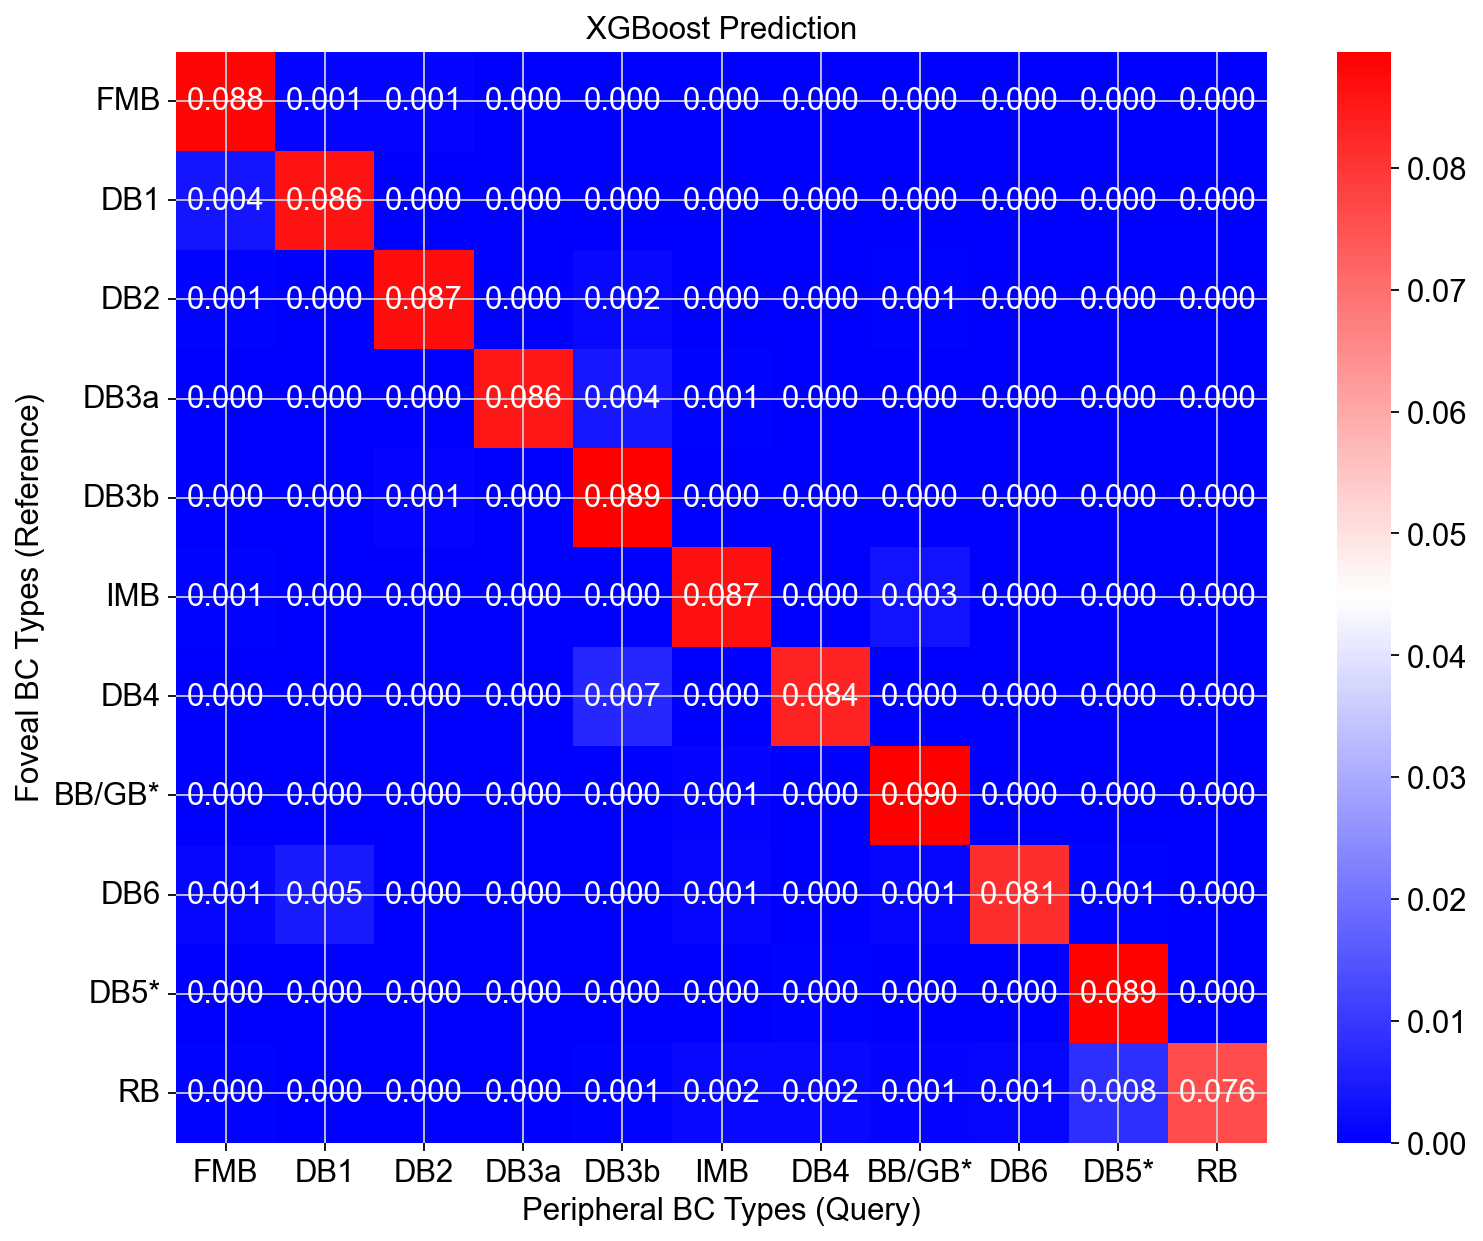

In [ ]:
existing_columns = [col for col in desired_order2 if col in cm.columns]
existing_rows = [row for row in desired_order1 if row in cm.index]

# Reindex both dimensions
cm_ordered = cm.reindex(index=existing_rows, columns=existing_columns)
# Normalize the matrix
cm_ordered = cm_ordered / cm_ordered.values.sum()

# Plot the ordered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ordered, cmap='bwr', square=True,
            annot=True, fmt='.3f')
plt.title("XGBoost Prediction")
plt.xlabel("Peripheral BC Types (Query)")
plt.ylabel("Foveal BC Types (Reference)")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./Plots/ot_bcs.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
cm_ordered

Predicted,FMB,DB1,DB2,DB3a,DB3b,IMB,DB4,BB/GB*,DB6,DB5*,RB
True,,,,,,,,,,,
FMB,0.088282,0.000712,0.000884,0.000098,0.000270,0.000074,0.000147,0.000344,0.000049,0.000049,0.000000
DB1,0.003666,0.086217,0.000147,0.000147,0.000000,0.000293,0.000147,0.000147,0.000000,0.000147,0.000000
DB2,0.000557,0.000056,0.087286,0.000056,0.001561,0.000334,0.000111,0.000502,0.000056,0.000334,0.000056
DB3a,0.000000,0.000276,0.000000,0.085659,0.004145,0.000553,0.000000,0.000276,0.000000,0.000000,0.000000
DB3b,0.000216,0.000087,0.000952,0.000087,0.089307,0.000000,0.000130,0.000043,0.000000,0.000087,0.000000
IMB,0.000530,0.000071,0.000124,0.000018,0.000177,0.086526,0.000035,0.003199,0.000141,0.000088,0.000000
DB4,0.000040,0.000040,0.000081,0.000121,0.006779,0.000081,0.083525,0.000081,0.000040,0.000081,0.000040
BB/GB*,0.000135,0.000067,0.000067,0.000000,0.000000,0.000945,0.000067,0.089559,0.000000,0.000067,0.000000
DB6,0.001234,0.004731,0.000206,0.000000,0.000000,0.001234,0.000206,0.001234,0.081242,0.000617,0.000206


In [24]:
matrix = cm_ordered

# Ensure the matrix is normalized
if not np.isclose(matrix.values.sum(), 1.0):
    matrix = matrix / matrix.values.sum()

# Calculate metrics
sparseness = sparseness_score(matrix.values)
entropy_value = entropy(matrix.values)
adi = adjusted_rand_index_from_confusion_matrix(matrix.values)


# Print results
print("\nCorrespondence Matrix Evaluation Results:")
print("----------------------------------------")
print(f"Sparseness Score: {sparseness:.4f}")
print(f"Entropy: {entropy_value:.4f}")
print(f"ADI: {adi:.4f}")

# Additional information about the matrix
print("\nMatrix Information:")
print(f"Shape: {matrix.shape}")
print(f"Number of cells: {matrix.size}")
print(f"Number of cells with value > 0.001: {np.sum(matrix.values > 0.001)}")
print(f"Maximum value: {matrix.values.max():.4f}")

# Calculate density (opposite of sparseness)
density = 1 - sparseness
print(f"Density (1-sparseness): {density:.4f}")

# Calculate concentration metrics
diag_sum = np.sum(np.diag(matrix.values)) if matrix.shape[0] == matrix.shape[1] else 0
print(f"Sum of diagonal elements: {diag_sum:.4f}")


Correspondence Matrix Evaluation Results:
----------------------------------------
Sparseness Score: 0.8017
Entropy: 2.6738
ADI: 0.8871

Matrix Information:
Shape: (11, 11)
Number of cells: 121
Number of cells with value > 0.001: 24
Maximum value: 0.0896
Density (1-sparseness): 0.1983
Sum of diagonal elements: 0.9427
